In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from random import choices
S = 250

T = 1000 # for the long term make T larger. 
#---------------------parameters for epsilon - greedy-----------------------
alpha = 0.5
eps = 0.3
gamma = 0.8
tau = 10

#--------threat, reward normalized here--------------
l = int(T/4)
neg_reward = np.array([-20,-30,-100,-40])
pos_reward = np.array([-50,-5,20,70])

#---------------function to figure out positive reward distribution-----------------

def pos_reward_density(pos_reward):
    # the prob of getting positive value from binary rewards
    # A: p = 0.5, B: p = 0.9, C: p = 0.5, D: p = 0.9
    
    
    return density

#------------------------------------------------------------------------------------
def normalize(rew):
    temp = np.concatenate((np.ones(l)*rew[0], np.ones(l)*rew[1], 
                           np.ones(l)*rew[2], np.ones(l)*rew[3]))
    norm = np.std(temp, ddof=1)
    return norm


std_thr = normalize(neg_reward)
std_rew = normalize(pos_reward) 

max_reward_mean = np.max(pos_reward)/std_rew 
max_threat_mean = np.max(neg_reward)/std_thr
print(std_thr)
print(std_rew)
print(max_reward_mean)
print(max_threat_mean)
#--------------------------------------------

def linear_scalar (Q, w, epsilon):
    temp = Q[0,:]*w[0] + Q[1,:]*w[1]
    if np.random.uniform(0,1) < epsilon:
        action = np.random.randint(0,4)
    else:
        action = np.random.choice(np.array(np.where(temp == np.amax(temp))).flatten())
    return action
# multiply might be in the psychiatry literature
# 
def softmax_one (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    #print(weights)
    population = np.arange(np.size(Q,1))
    
    action = choices(population, weights)
    return action[0]

def softmax_two (Q, w, tau):
    ex_zero =  np.exp((Q[0,:] - np.max(Q[0,:]))/tau)
    weights_zero = ex_zero/np.sum(ex_zero)
    ex_one =  np.exp((Q[1,:] - np.max(Q[1,:]))/tau)
    weights_one = ex_one/np.sum(ex_zero)
    
    weights = w[0]*weights_zero + w[1]*weights_one
    #print('-----------')
    #print(w)
    #print(weights_zero, weights_one)
    #print(weights)
    population = np.arange(np.size(Q,1))

    action = choices(population, weights)
    
    return action[0]
    
def update(curr_action, Q, next_action, r, obj):
    predict = Q[obj, curr_action]
    target = r+ gamma*Q[obj, next_action]
    Q[obj, curr_action] = Q[obj, curr_action]*(1-alpha) + alpha*target

#---------THIS IS WHERE REWARDS ARE CHANGED----------------
# DEFAULT IS {-25,-25,25,25}
# 1) {-50,-25,25,25} looks linear
# 2) {-50,-5, 20, 70 } also looks linear
# 3) {-50,-5, 20, 70} and {0,0,-1,-3} looks almos linear. 
def step(curr_action):
    # actions {0,1,2,3} correspond to decks {A,B,C,D}
    if curr_action == 0:
        reward = pos_reward[0]
        threat = neg_reward[0]
    elif curr_action == 1:
        reward = pos_reward[1]
        threat = neg_reward[1]
    elif curr_action == 2:
        reward = pos_reward[2]
        threat = neg_reward[2]
    else:
        reward = pos_reward[3]
        threat = neg_reward[3]
    reward/=std_rew
    threat/=std_thr
    return reward, threat

#----------------TRAINING STARTS HERE --------------------
# partition parameter
p = 0.02
W = int(1/p) + 1

Q = np.zeros((S,2,4,W))

reward_regret = np.zeros((S,T,W))
threat_regret = np.zeros((S,T,W))
actions = np.zeros((S,4,W))



for w in range(W):
    weight = [w*p, 1.0-w*p]
    #print(weight)
    for s in range(S):
        for t in range(T):
            curr_action = linear_scalar(Q[s,:,:,w], weight, eps)
            #print("action = ", curr_action)
            actions[s,curr_action,w]+=1
            reward, threat = step(curr_action)
            
            #print("reward = ", np.round(reward,3))
            #print("threat = ", np.round(threat,3))
            next_action = linear_scalar(Q[s,:,:,w], weight, 0.0)
            
            update(curr_action, Q[s,:,:,w], next_action, reward, 0)
            update(curr_action, Q[s,:,:,w], next_action, threat, 1)
            #print(np.round(Q[s,:,:,w],3))
            reward_regret[s,t,w] = max_reward_mean - reward
           
            threat_regret[s,t,w] = max_threat_mean - threat
            


31.14032305098519
43.37705694337813
1.6137563249478613
-0.6422540950283191


In [2]:
# only picking deck A
rew = pos_reward/std_rew
regret = max_reward_mean - rew
print("pure reward regrets", regret)

thr = neg_reward/std_thr
thr_regret = max_threat_mean - thr
print("pure threat regret ", thr_regret)
print(weight)

pure reward regrets [2.76643941 1.72902463 1.15268309 0.        ]
pure threat regret  [0.         0.32112705 2.56901638 0.6422541 ]
[1.0, 0.0]


In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20,12), dpi=80)

x = np.arange(T)
plt.figure(1)
cum_rew_regret = np.zeros((T,W))
cum_thr_regret = np.zeros((T,W))
for w in range(W):
    cum_rew_regret[:,w] = np.cumsum(np.mean(reward_regret[:,:,w], 0))
    cum_thr_regret[:,w] = np.cumsum(np.mean(threat_regret[:,:,w], 0))
#     plt.subplot(7,8,w+1)
#     plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w])
    #plt.legend(['reward regret', 'threat regret'])
    #print(cum_rew_regret)
# now plot time-averaged regrets

for t in range(T):
    cum_rew_regret[t,:]/=(t+1)
    cum_thr_regret[t,:]/=(t+1)

# figure(figsize=(20,12), dpi=80)
# plt.figure(2)
# for w in range(W):
#     plt.subplot(7,8,w+1)
#     plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w] )

<Figure size 1600x960 with 0 Axes>

In [4]:
# some debugging
# debugging a bit here\n",
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
for w in range(W):
    print(w*p, np.mean(actions[:,:,w], 0))
#     print(np.round(np.mean(Q[:,0,:,w]*w+Q[:,1,:,w]*(W-w), axis=(0,1)),2))


0.0 [761.996  82.932  75.28   79.792]
0.02 [760.848  83.356  76.372  79.424]
0.04 [760.488  83.228  76.152  80.132]
0.06 [758.192  84.188  77.288  80.332]
0.08 [756.976  85.24   75.992  81.792]
0.1 [752.924  86.092  77.784  83.2  ]
0.12 [754.268  87.136  75.68   82.916]
0.14 [749.468  88.192  76.396  85.944]
0.16 [744.728  89.056  76.336  89.88 ]
0.18 [733.924  90.124  76.128  99.824]
0.2 [ 96.856  90.592  76.4   736.152]
0.22 [ 89.072  87.212  75.316 748.4  ]
0.24 [ 84.136  86.216  75.804 753.844]
0.26 [ 82.472  83.032  76.032 758.464]
0.28 [ 80.788  82.5    75.956 760.756]
0.3 [ 79.36   81.624  76.012 763.004]
0.32 [ 78.692  80.388  77.396 763.524]
0.34 [ 78.028  78.956  75.368 767.648]
0.36 [ 77.26   78.696  75.036 769.008]
0.38 [ 76.492  76.672  76.028 770.808]
0.4 [ 75.712  76.512  75.268 772.508]
0.42 [ 75.904  76.104  75.676 772.316]
0.44 [ 75.536  75.62   76.436 772.408]
0.46 [ 75.788  75.468  76.348 772.396]
0.48 [ 75.856  75.644  75.548 772.952]
0.5 [ 75.228  75.072  75.224 7

<Figure size 1280x800 with 0 Axes>

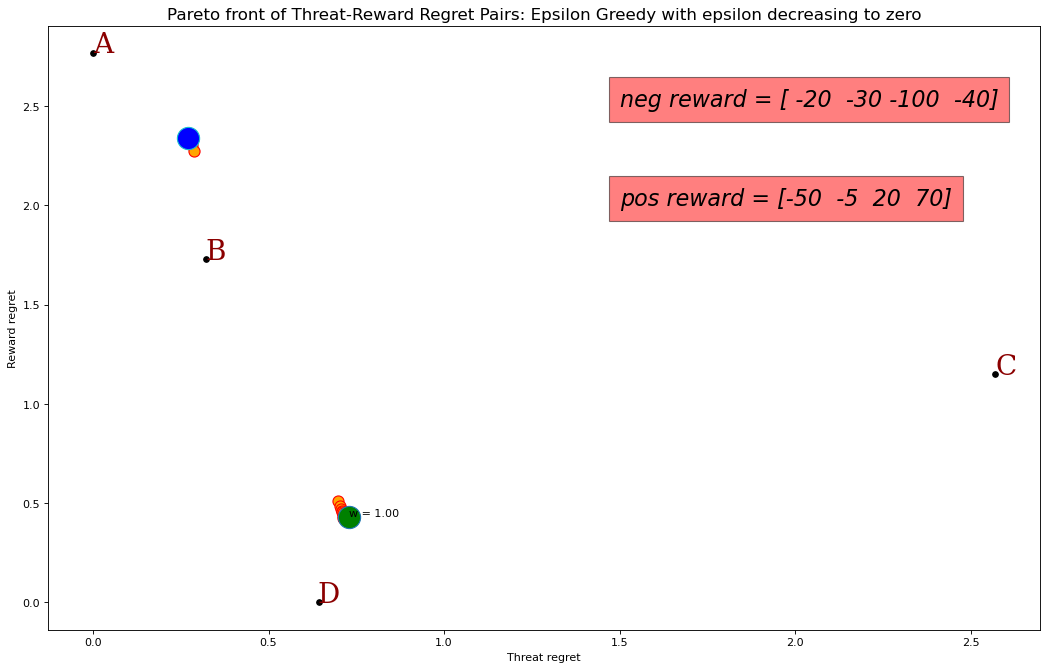

In [5]:
# plotting asymptotics against the weight.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
np.shape(reward_regret)
y = cum_rew_regret[T-1,:] # make T larger average over last few time steps
x = cum_thr_regret[T-1,:]
# print(x)
# print(y)
annotations=[]

for w in range(W):
    f = format(w*p, ".2f")
    annotations = np.append(annotations,"w = "+str(f) )
plt.scatter(x,y, s=40)
plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
plt.title("Pareto front of Threat-Reward Regret Pairs: Epsilon Greedy with epsilon decreasing to zero",fontsize=15)
# for i, label in enumerate(annotations):
#     plt.annotate(label, (x[i], y[i]))
# print(annotations)

plt.text(1.5,2.0, 'pos reward = ' + str(pos_reward), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)
plt.text(1.5,2.5, 'neg reward = ' + str(neg_reward), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)


# Pareto front plotter
# returns true only if (a,b) is not Pareto dominated by (a1,b1)
def isPareto(a,b,a1,b1):
    if a1 > a:
        return True
    elif b1 > b:
        return True
    else:
        return False
#print(isPareto(0.2,0.2,0.2,0.2))

n = np.size(x)
for i in range(n):
    count = 0
    for j in range(n):
        if  isPareto(x[i], y[i], x[j], y[j]):
            count+=1
    #print(x[i], y[i])
    #print(count)
    if count==n-1:
#         print(x[i],y[i])
        plt.plot(x[i], y[i],marker="o",markersize=10, markeredgecolor="red",
            markerfacecolor="orange")
#         plt.annotate(x[i], y[i])
plt.plot(x[0], y[0], marker = "o", markersize = 20, markerfacecolor = "blue")
plt.plot(x[n-1], y[n-1], marker = "o", markersize = 20, markerfacecolor = "green")

plt.annotate(annotations[n-1], (x[n-1], y[n-1]))    
plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
plt.show()

In [6]:
# Pareto front plotter
# Decides if (a,b) Pareto Dominates (a1,b1)
def isPareto(a,b,a1,b1):
    if a>a1:
        return False
    elif b>b1:
        return False
    else:
        return True
